Twitter Sentiment Analysis 

In [1]:
#Importing necessary libraries

In [2]:
!pip install mlxtend
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]

EDA

First five records in the dataset

In [5]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Last five records in the dataset

In [6]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


Empty DataFrame
Columns: [label, time, date, query, username, text]
Index: []
0   2009-04-06 22:19:49
1   2009-04-06 22:19:53
2   2009-04-06 22:19:57
3   2009-04-06 22:19:57
4   2009-04-06 22:20:00
Name: date, dtype: datetime64[ns]


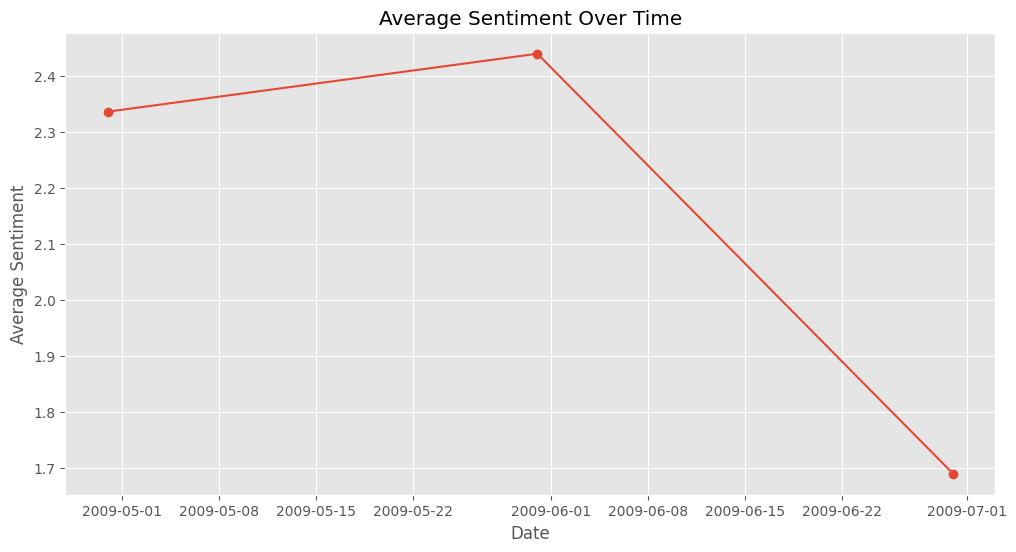

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data into a DataFrame
# For example: data = pd.read_csv('path_to_your_data.csv')

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Check for any errors during conversion
print(data[data['date'].isnull()])

# Drop rows with missing dates
data.dropna(subset=['date'], inplace=True)

# Check the converted date column
print(data['date'].head())

# Set the date column as the index
data.set_index('date', inplace=True)

# Resample by month and calculate the mean sentiment
monthly_sentiment = data['label'].resample('M').mean()

# Plot the monthly sentiment
plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment, marker='o')
plt.title('Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()


Columns or features in the dataset

In [8]:
data.columns

Index(['label', 'time', 'query', 'username', 'text'], dtype='object')

Length of the data 

In [9]:
print('lenght of data is', len(data))

lenght of data is 1599999


Data Shape

In [10]:
data.shape

(1599999, 5)

Data Information

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1599999 entries, 2009-04-06 22:19:49 to 2009-06-16 08:40:50
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   query     1599999 non-null  object
 3   username  1599999 non-null  object
 4   text      1599999 non-null  object
dtypes: int64(2), object(3)
memory usage: 73.2+ MB


Names and data type of all the columns

In [12]:
data.dtypes

label        int64
time         int64
query       object
username    object
text        object
dtype: object

Checking for null values in the dataset

In [13]:
np.sum(data.isnull().any(axis=1))

0

Number of rows and columns in the dataset

In [14]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   5


In [15]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   1599999


Selecting the text and label column

In [16]:
data=data[['text','label']]

Assigning 1 to Positive sentiment 4

Separating positive and negative tweets

In [17]:
data['label'][data['label']==4]=1

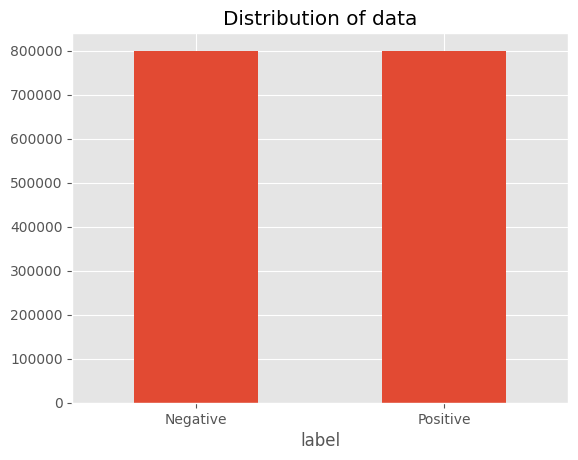

In [18]:
# Plotting the distribution for dataset.
ax = data.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, label = list(data['text']), list(data['label'])

In [19]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [20]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

Combining positive and negative tweets

In [21]:
data = pd.concat([data_pos, data_neg])

Making statement text in lower case

In [22]:
data['text']=data['text'].str.lower()

In [23]:
data['text'].tail()

date
2009-04-19 01:19:30                            one more day of holidays 
2009-04-19 01:19:32    feeling so down right now .. i hate you damn h...
2009-04-19 01:19:34    geez,i hv to read the whole book of personalit...
2009-04-19 01:19:34    i threw my sign at donnie and he bent over to ...
2009-04-19 01:19:44    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

Cleaning and removing Stop words of english

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anujk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
stopwords_list = stopwords.words('english')

In [26]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

Cleaning and removing the above stop words list from the tweet text

In [27]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

date
2009-04-06 22:22:45                love @health4uandpets u guys r best!!
2009-04-06 22:22:45    im meeting one besties tonight! cant wait!! - ...
2009-04-06 22:22:46    @darealsunisakim thanks twitter add, sunisa! g...
2009-04-06 22:22:46    sick really cheap hurts much eat real food plu...
2009-04-06 22:22:46                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

Removing punctuations 

In [28]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [29]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

date
2009-04-19 01:19:30                                     one day holidays
2009-04-19 01:19:32                     feeling right  hate damn humprey
2009-04-19 01:19:34    geezi hv read whole book personality types emb...
2009-04-19 01:19:34     threw sign donnie bent get thingee made sad face
2009-04-19 01:19:44    heather2711 good thing find none ones like com...
Name: text, dtype: object

Removing repeating characters

In [30]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [31]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

date
2009-04-19 01:19:30                                     one day holidays
2009-04-19 01:19:32                       feling right hate damn humprey
2009-04-19 01:19:34    gezi hv read whole bok personality types embar...
2009-04-19 01:19:34       threw sign donie bent get thinge made sad face
2009-04-19 01:19:44    heather271 god thing find none ones like come ...
Name: text, dtype: object

Removing email

In [32]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [33]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

date
2009-04-19 01:19:30                                     one day holidays
2009-04-19 01:19:32                       feling right hate damn humprey
2009-04-19 01:19:34    gezi hv read whole bok personality types embar...
2009-04-19 01:19:34       threw sign donie bent get thinge made sad face
2009-04-19 01:19:44    heather271 god thing find none ones like come ...
Name: text, dtype: object

Removing URL's

In [34]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [35]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

date
2009-04-19 01:19:30                                     one day holidays
2009-04-19 01:19:32                       feling right hate damn humprey
2009-04-19 01:19:34    gezi hv read whole bok personality types embar...
2009-04-19 01:19:34       threw sign donie bent get thinge made sad face
2009-04-19 01:19:44    heather271 god thing find none ones like come ...
Name: text, dtype: object

Removing Numeric numbers

In [36]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [37]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

date
2009-04-19 01:19:30                                     one day holidays
2009-04-19 01:19:32                       feling right hate damn humprey
2009-04-19 01:19:34    gezi hv read whole bok personality types embar...
2009-04-19 01:19:34       threw sign donie bent get thinge made sad face
2009-04-19 01:19:44    heather god thing find none ones like come siz...
Name: text, dtype: object

Tokenization of tweet text

In [38]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [39]:
data['text'].head()

date
2009-04-06 22:22:45             [love, healthuandpets, u, guys, r, best]
2009-04-06 22:22:45    [im, meting, one, besties, tonight, cant, wait...
2009-04-06 22:22:46    [darealsunisakim, thanks, twiter, ad, sunisa, ...
2009-04-06 22:22:46    [sick, realy, cheap, hurts, much, eat, real, f...
2009-04-06 22:22:46                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

Applying Stemming

In [40]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [41]:
data['text'].head()

date
2009-04-06 22:22:45             [love, healthuandpets, u, guys, r, best]
2009-04-06 22:22:45    [im, meting, one, besties, tonight, cant, wait...
2009-04-06 22:22:46    [darealsunisakim, thanks, twiter, ad, sunisa, ...
2009-04-06 22:22:46    [sick, realy, cheap, hurts, much, eat, real, f...
2009-04-06 22:22:46                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

 Lemmatizer

In [42]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anujk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

In [44]:
data['text'].head()

date
2009-04-06 22:22:45             [love, healthuandpets, u, guys, r, best]
2009-04-06 22:22:45    [im, meting, one, besties, tonight, cant, wait...
2009-04-06 22:22:46    [darealsunisakim, thanks, twiter, ad, sunisa, ...
2009-04-06 22:22:46    [sick, realy, cheap, hurts, much, eat, real, f...
2009-04-06 22:22:46                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [45]:
data.head()

,text,label
date,,
2009-04-06 22:22:45,"[love, healthuandpets, u, guys, r, best]",1
2009-04-06 22:22:45,"[im, meting, one, besties, tonight, cant, wait...",1
2009-04-06 22:22:46,"[darealsunisakim, thanks, twiter, ad, sunisa, ...",1
2009-04-06 22:22:46,"[sick, realy, cheap, hurts, much, eat, real, f...",1
2009-04-06 22:22:46,"[lovesbroklyn, efect, everyone]",1


In [46]:
!pip install wordcloud
from wordcloud import WordCloud

Defaulting to user installation because normal site-packages is not writeable


In [47]:
data_pos

,text,label
date,,
2009-04-06 22:22:45,I LOVE @Health4UandPets u guys r the best!!,1
2009-04-06 22:22:45,im meeting up with one of my besties tonight! ...,1
2009-04-06 22:22:46,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
2009-04-06 22:22:46,Being sick can be really cheap when it hurts t...,1
2009-04-06 22:22:46,@LovesBrooklyn2 he has that effect on everyone,1
...,...,...
2009-04-18 14:39:51,We just met some awesome people at T.G.I Fridays,1
2009-04-18 14:39:52,oh my goodness . my feet are the most sensitiv...,1
2009-04-18 14:39:52,@hey_angy hahaha,1


In [48]:
data_neg

,text,label
date,,
2009-04-06 22:19:49,is upset that he can't update his Facebook by ...,0
2009-04-06 22:19:53,@Kenichan I dived many times for the ball. Man...,0
2009-04-06 22:19:57,my whole body feels itchy and like its on fire,0
2009-04-06 22:19:57,"@nationwideclass no, it's not behaving at all....",0
2009-04-06 22:20:00,@Kwesidei not the whole crew,0
...,...,...
2009-04-19 01:19:30,One more day of holidays,0
2009-04-19 01:19:32,feeling so down right now .. i hate you DAMN H...,0
2009-04-19 01:19:34,"geez,i hv to READ the whole book of personalit...",0


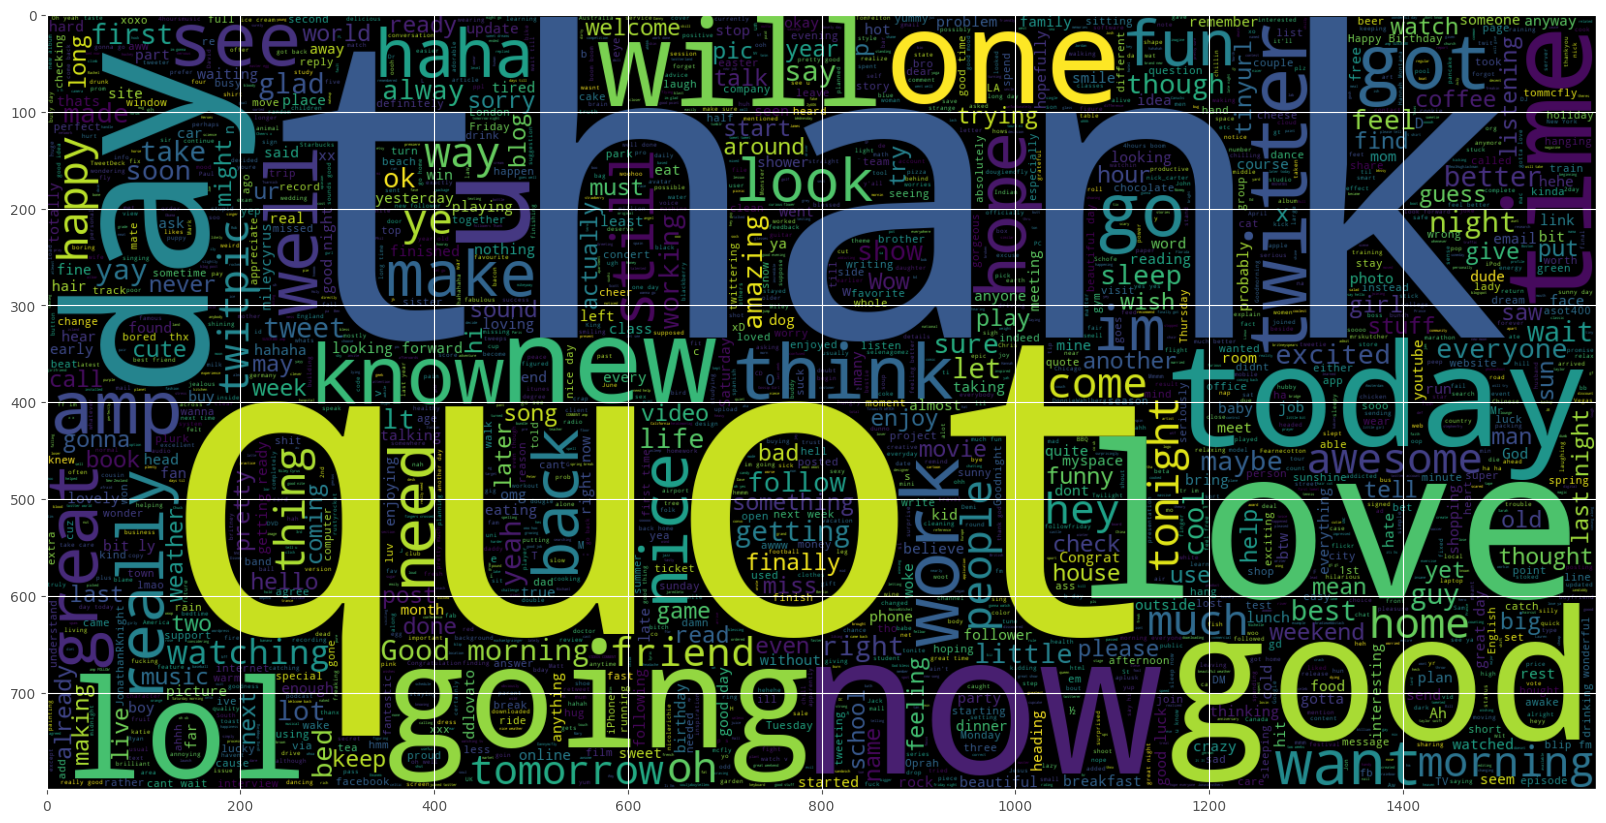

In [49]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_pos[data_pos.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

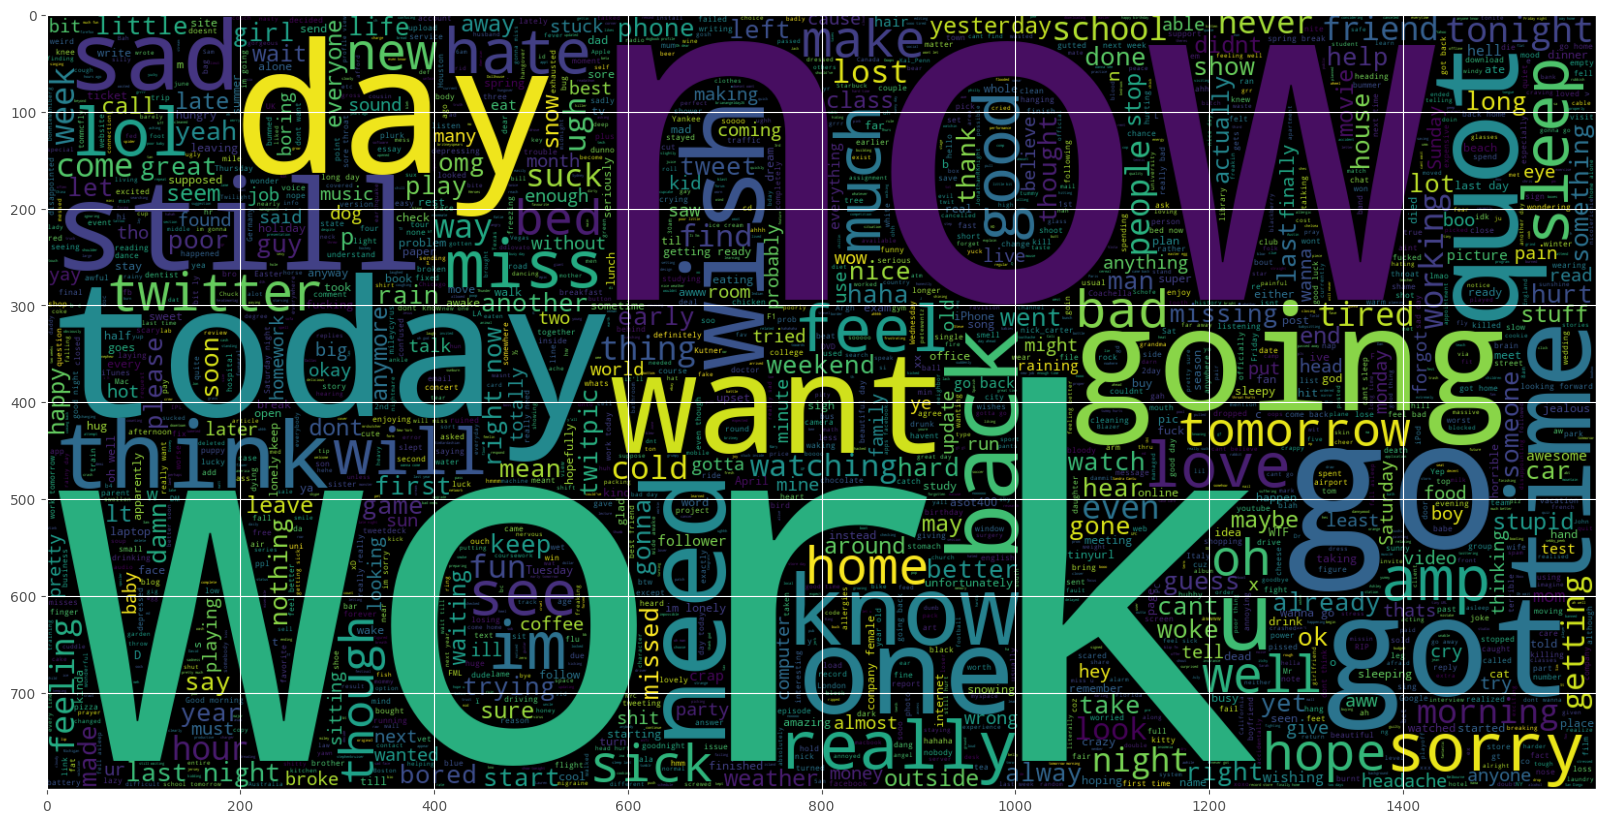

In [50]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_neg[data_neg.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [51]:
data['label'].nunique()

2

Separating input feature and label

In [52]:
X=data.text
y=data.label

Preparing the input features for training 
- Converting text words into arrays form. 
- Maximum 500 features/words selected for training. These 500 words will be selected on the importance that will distinguish between the positive tweets and negative tweets. 

In [53]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

As it can be observed there total 40000 tweets and the number words/features are 500.

In [54]:
sequences_matrix.shape

(40000, 500)

Separating the 70% data for training data and 30% for testing data

As we prepared all the tweets, now we are separating/splitting the tweets into training data and testing data.
- 70% tweets will be used in the training 
- 30% tweets will be used to test the performance of the model.

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

Implementing Tensorflow based model for training 

Step 1
- The input to model is 500 words because these are the number of features/words that were extracted above from text of tweets.

Step 2
- Embeddings provide the presentation of words and their relative meanings. Like in this, we are feeding the limit of maximum words, lenght of input words and the inputs of previous layer. 

Step 3
- LSTM (long short term memory) saves the words and predict the next words based on the previous words. LSTM is a sequence predictor of next coming words.

Step 4
- Dense layer reduces the outputs by getting inputs from Flatten layer. Dense layer uses all the inputs of previous layer neurons and performs calculations and send 256 outputs

Step 5
- Activation function is the node that is put at the end of all layers of neural network model or in between neural network layers. Activation function helps to decide which neuron should be passed and which neuron should fire. So activation function of node defines the output of that node given an input or set of inputs. 

Step 6
- Dropout layer drops some neurons from previous layers. We apply this to avoid the overfitting problem. In overfitting, model gives good accuracy on training time but not on testing.


In [56]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

Model compilation

- Firstly we are calling the model
- We are using 2 classes so we set "binary_crossentropy" and if we use more than two classes then we use "categorical_crossentropy" 
- Optimizer is a function that is used to change the features of neural network such as learning rate (how the model learns with features) in order to reduce the losses. So the learning rate of neural network to reduce the losses is defined by optimizer.
- We are setting metrics=accuracy because we are going to caluclate the percentage of correct predictions over all predictions on the validation set

In [57]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  

Training and validating with parameter tuning
- We are feeding the training data and getting 10% data for validation from training data
- We set the following parameters:
- Batch size =80 so the model take 80 tweets in each iteration and train them. Batch size is a term used in machine learning and refers to the number of training examples utilized in one iteration. 
- Epochs =6 so the model will train on the data 6 times.Epoch is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed. 
- We can choose batch_size, and epochs as we want so the good practice is to set some values and train the model if the model will not give the good results we can change it and then try again for the training of the model. We can repeat this process many time untill we get the good results and this process called as parameter tuning.


In [58]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 47s 145ms/step - accuracy: 0.5686 - loss: 0.6636 - val_accuracy: 0.7193 - val_loss: 0.5392
Epoch 2/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 45s 143ms/step - accuracy: 0.7489 - loss: 0.5163 - val_accuracy: 0.7411 - val_loss: 0.5298
Epoch 3/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.7711 - loss: 0.4886 - val_accuracy: 0.7389 - val_loss: 0.5184
Epoch 4/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.7467 - loss: 0.5259 - val_accuracy: 0.7493 - val_loss: 0.5243
Epoch 5/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 45s 143ms/step - accuracy: 0.7667 - loss: 0.4878 - val_accuracy: 0.7464 - val_loss: 0.5235
Epoch 6/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 45s 143ms/step - accuracy: 0.7721 - loss: 0.4774 - val_accuracy: 0.7457 - val_loss: 0.5166
Training finished !!


In [59]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7383 - loss: 0.5204


Accuracy
- Accuracy is the number of correctly classify tweets from all the tweets of positive and negative. 
- For example, if the trained model classify the 70 tweets correct and 30 tweets wrong from total of 100 tweets then the accuracy score will be 70%. 
- Accuracy= Total number of correct predictions/Total number of predictions

In [60]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.74


#### Getting prediction of the test data and then we will compare the true labels/classes of the data with predictions
- As the model give probabilties so we are setting a threshold 0.5. More than 0.5 will be the positive tweets and lower will be negative tweets

In [61]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step


#### Confusion matrix
- These are the evaluation measures to evaluate the performance of the model.
- Dark blue boxes are the correct predictions with the trained model and sky blue boxes shows the wrong predictions.
- 4610 tweets correctly predicted as negative sentiments. 1399 tweets predicted positive sentiments but that were actually negative sentiments.
- 4247 tweets correctly predicted as postive sentiments. 1744 tweets predicted negative sentiments but that were actually positive sentiments.



confusion matrix


[[4460 1549]
 [1535 4456]]




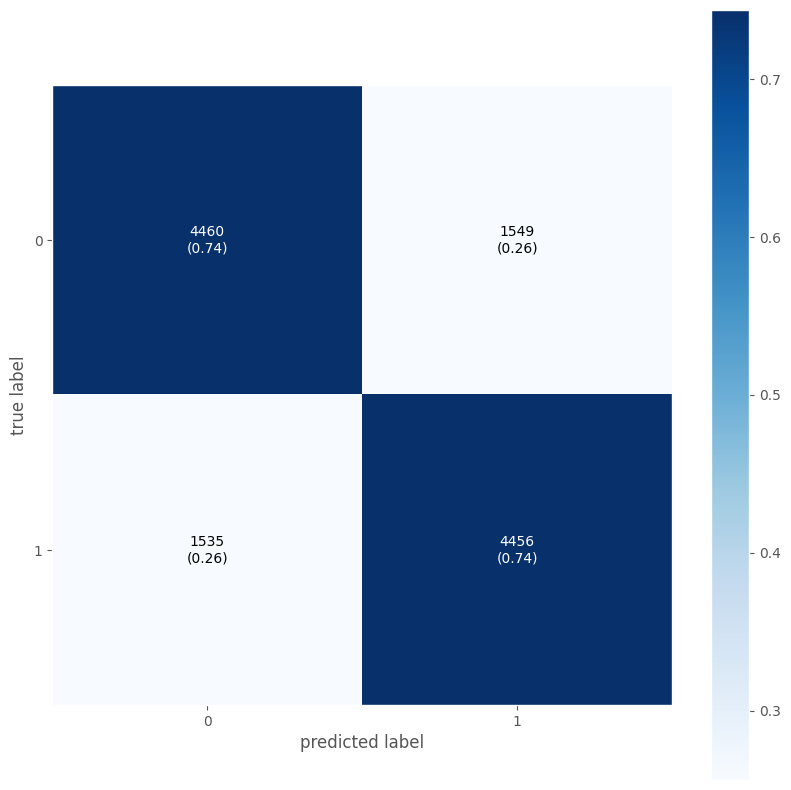

In [62]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# ROC CURVE
- ROC curve show the performance of the model as well. 
- We can see that the model started from the 0 percent predictions and then moved to true positive predictions that are correct
- ROC curve (receiver operating characteristic curve) show the performance of a classification model at all the classification thresholds. ROC plots two parameters, True Positive Rate (correct predictions/classifications) False Positive Rate (wrong predictions/classifications)

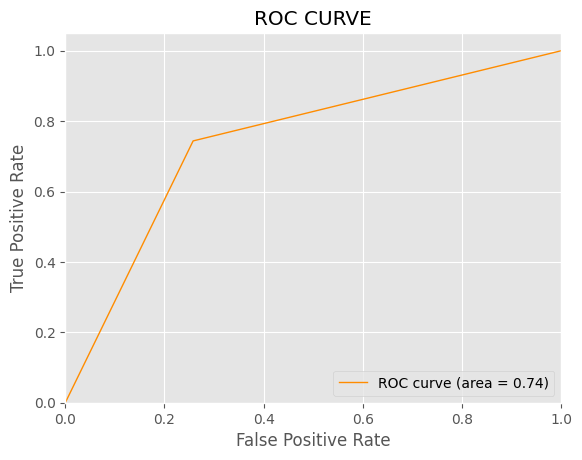

In [63]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()